In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import jellyfish
import time
import ngram

## Read similarity scores for pairs of processes from the matrix

We want to look up the code of processes, in snakemake and in nextflow, as well as their levenshtein and 3-gram similarity scores. 
We want to look up pairs of similar and different sizes, small and large processes, processes that are very reused vs processes that are similar to very little other processes, processes using the same tool and not.

In [3]:
#import similarity matrices
path_matrix_nf_lev="/home/marinedjaffardjy/Documents/Code/Similarite_process/json/matrix_nf_levenshtein"
path_matrix_snk_lev="/home/marinedjaffardjy/Documents/Code/Similarite_process/json/matrix_snk_levenshtein"
path_matrix_nf_ngram="/home/marinedjaffardjy/Documents/Code/Similarite_process/json/matrix_nf_ngram"
path_matrix_snk_ngram="/home/marinedjaffardjy/Documents/Code/Similarite_process/json/matrix_snk_ngram"


In [4]:
def importing_json_files(file_wf):
    f_wf = open(file_wf) #informations for nf
    # returns JSON object as
    # a dictionary
    wf = json.load(f_wf)
    f_wf.close
    return wf

#importing the wf and auth dict (github info)
dict_nf = importing_json_files('../json/wf_new_crawl_nextflow.json')
auth_nf = importing_json_files('../json/author_clem_nf.json')
dict_snk = importing_json_files('../json/wf_crawl_snakemake.json')
auth_snk = importing_json_files('../json/author_clem_snk.json')

#import processes dictionnaries
#snakemake rules
with open('/home/marinedjaffardjy/Documents/Code/Investigating_reuse/json/snk_rule_info_tool.json') as f:
    snk_proc = json.load(f)
#nf proc
with open('/home/marinedjaffardjy/Documents/Code/Similarite_process/json/nf_proc_tool.json') as f:
    nf_proc = json.load(f)

examinons différents seuils :
- 0.80
- 0.85
- 0.90
- 0.95

In [5]:
def get_matrix_files(path_matrix,nb_proc):
    mat_nf_ngram=[]
    i=50
    while i <=(nb_proc-1):
        matrix_filename= path_matrix+"/matrix_"+str(i)+".json"
        mat_nf_ngram.append(matrix_filename)
        i+=50
    if((nb_proc-1)%50!=0):
        matrix_filename= path_matrix+"/matrix_"+str(nb_proc-1)+".json"
        mat_nf_ngram.append(matrix_filename) 
    return mat_nf_ngram

In [6]:
mat_nf_lev = get_matrix_files(path_matrix_nf_lev,9652)
mat_nf_ngram = get_matrix_files(path_matrix_nf_ngram,9652)
mat_snk_lev = get_matrix_files(path_matrix_snk_lev,5001)
mat_snk_ngram = get_matrix_files(path_matrix_snk_ngram,5001)

In [7]:
def get_pairs_brackets(mat_nf_lev):
    seuils = [0.80,0.85,0.90,0.95]
    i=0
    paires3=[]
    paires2=[]
    paires1=[]
    paires0=[]
    for file in mat_nf_lev:
        with open(file) as f:
            new_lines=json.load(f)
        for line in new_lines:
            for j in range(0,len(line)):
                if(i!=j):
                    if(line[j]>seuils[3]):
                        paires3.append([i,j])
                    elif(line[j]>seuils[2]):
                        paires2.append([i,j])
                    elif(line[j]>seuils[1]):
                        paires1.append([i,j])
                    elif(line[j]>seuils[0]):
                        paires0.append([i,j])
            i+=1
    return [paires0,paires1,paires2,paires3]


In [8]:
%%time

paires_lev_nf = get_pairs_brackets(mat_nf_lev)


CPU times: user 48.4 s, sys: 1.44 s, total: 49.9 s
Wall time: 52 s


In [9]:
%%time

paires_lev_snk = get_pairs_brackets(mat_snk_lev)

CPU times: user 12.3 s, sys: 372 ms, total: 12.6 s
Wall time: 13.3 s


In [10]:
#find pairs same tools and diff tools
def find_diff_tools(tools_nf, pairs0):
    same_tools = []
    diff_tools = []
    for pair in pairs0:
        if(tools_nf[pair[0]]==tools_nf[pair[1]]):
            same_tools.append(pair)
        else:
            diff_tools.append(pair)
    return same_tools,diff_tools

In [11]:
same_tools_nf=[]
diff_tools_nf=[]
tools_nf=[el["tools"] for el in nf_proc]
for i in range(0,4):
    same_new,diff_new=find_diff_tools(tools_nf,paires_lev_nf[i])
    same_tools_nf.append(same_new)
    diff_tools_nf.append(diff_new)

In [33]:
seuils = [0.80,0.85,0.90,0.95]
for i in range(0,4):
    print("seuils "+str(seuils[i]))
    print(len(same_tools_nf[i]))
    print(len(diff_tools_nf[i]))

seuils 0.8
811
7004
seuils 0.85
483
4168
seuils 0.9
368
4012
seuils 0.95
931
9441


In [13]:
def display_codes(pair,nf_proc,mat_files_lev, mat_files_ngram):
    
    code1 = nf_proc[pair[0]]["code"]
    code2 = nf_proc[pair[1]]["code"]
    file_nb = int(pair[0]/50)
    with open(mat_files_lev[file_nb]) as f:
        mat_lev = json.load(f)
    with open(mat_files_ngram[file_nb]) as f:
        mat_ngram = json.load(f)
        
    levenshtein = mat_lev[pair[0]%50][pair[1]]
    score_ngram = mat_ngram[pair[0]%50][pair[1]]
    
    print(f"LEVENSHTEIN : {levenshtein} \nNGRAM : {score_ngram} \n")
    print("PROCESS 1")
    print(code1)
    print("PROCESS 2")
    print(code2)

Let us take a look at some examples of processes that have similar and different tools, for the same score brackets

In [14]:
display_codes(same_tools_nf[0][64],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.8238747553816047 
NGRAM : 0.7724498692240628 

PROCESS 1
process BEDTOOLS_MASKFASTA {
    tag "$meta.id"
    label 'process_medium'

    conda (params.enable_conda ? "bioconda::bedtools=2.30.0" : null)
    container "${ workflow.containerEngine == 'singularity' && !task.ext.singularity_pull_docker_container ?
        'https://depot.galaxyproject.org/singularity/bedtools:2.30.0--hc088bd4_0' :
        'quay.io/biocontainers/bedtools:2.30.0--hc088bd4_0' }"

    input:
    tuple val(meta), path(bed)
    path  fasta

    output:
    tuple val(meta), path("*.fa"), emit: fasta
    path "versions.yml"          , emit: versions

    when:
    task.ext.when == null || task.ext.when

    script:
    def args = task.ext.args ?: ''
    def prefix = task.ext.prefix ?: "${meta.id}"
    """
    bedtools \\
        maskfasta \\
        $args \\
        -fi $fasta \\
        -bed $bed \\
        -fo ${prefix}.fa
    cat <<-END_VERSIONS > versions.yml
    "${task.process}":
        bedtoo

In [15]:
display_codes(diff_tools_nf[0][76],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.8043117744610282 
NGRAM : 0.8252351097178683 

PROCESS 1

process SAMTOOLS_SORT {
    tag "$meta.id"
    label 'process_medium'
    publishDir "${params.outdir}",
        mode: params.publish_dir_mode,
        saveAs: { filename -> saveFiles(filename:filename, options:params.options, publish_dir:getSoftwareName(task.process), meta:meta, publish_by_meta:['id']) }

    conda (params.enable_conda ? 'bioconda::samtools=1.13' : null)
    if (workflow.containerEngine == 'singularity' && !params.singularity_pull_docker_container) {
        container "https://depot.galaxyproject.org/singularity/samtools:1.13--h8c37831_0"
    } else {
        container "quay.io/biocontainers/samtools:1.13--h8c37831_0"
    }

    input:
    tuple val(meta), path(bam)

    output:
    tuple val(meta), path("*.bam"), emit: bam
    path  "versions.yml"          , emit: versions

    script:
    def prefix   = options.suffix ? "${meta.id}${options.suffix}" : "${meta.id}"
    """
    samtools sort $op

In [16]:
display_codes(same_tools_nf[1][122],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.8922651933701657 
NGRAM : 0.8337531486146096 

PROCESS 1

process fastqc {
    tag "$name"
    publishDir "${params.outdir}/fastqc", mode: 'copy',
        saveAs: {filename -> filename.indexOf(".zip") > 0 ? "zips/$filename" : "$filename"}

    input:
    set val(name), file(reads) from raw_reads_fastqc

    output:
    file "*_fastqc.{zip,html}" into fastqc_results

    script:
    """
    fastqc -q $reads
    """
}
PROCESS 2

process fastqc {
    tag "${reads[0].baseName}"
    publishDir "${params.outdir}/fastqc", mode: 'copy',
        saveAs: {filename -> filename.indexOf(".zip") > 0 ? "zips/$filename" : "$filename"}

    input:
    file reads from read_files_fastqc

    output:
    file "*_fastqc.{zip,html}" into fastqc_results

    script:
    """
    fastqc -q $reads
    """
}


In [17]:
display_codes(diff_tools_nf[1][46],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.886411889596603 
NGRAM : 0.8386108273748724 

PROCESS 1
process SAMTOOLS_IDXSTATS {
    tag "$meta.id"
    label 'process_low'

    conda (params.enable_conda ? "bioconda::samtools=1.14" : null)
    container "${ workflow.containerEngine == 'singularity' && !task.ext.singularity_pull_docker_container ?
        'https://depot.galaxyproject.org/singularity/samtools:1.14--hb421002_0' :
        'quay.io/biocontainers/samtools:1.14--hb421002_0' }"

    input:
    tuple val(meta), path(bam), path(bai)

    output:
    tuple val(meta), path("*.idxstats"), emit: idxstats
    path  "versions.yml"               , emit: versions

    script:
    def args = task.ext.args ?: ''
    """
    samtools idxstats $bam > ${bam}.idxstats
    cat <<-END_VERSIONS > versions.yml
    "${task.process}":
        samtools: \$(echo \$(samtools --version 2>&1) | sed 's/^.*samtools //; s/Using.*\$//')
    END_VERSIONS
    """
}
PROCESS 2
process MULTIQC {
    label 'process_medium'

    conda (params

In [18]:
display_codes(same_tools_nf[2][248],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.9202453987730062 
NGRAM : 0.8306374881065651 

PROCESS 1
process SAMTOOLS_IDXSTATS {
    tag "$meta.id"
    label 'process_low'

    conda (params.enable_conda ? "bioconda::samtools=1.14" : null)
    container "${ workflow.containerEngine == 'singularity' && !task.ext.singularity_pull_docker_container ?
        'https://depot.galaxyproject.org/singularity/samtools:1.14--hb421002_0' :
        'quay.io/biocontainers/samtools:1.14--hb421002_0' }"

    input:
    tuple val(meta), path(bam), path(bai)

    output:
    tuple val(meta), path("*.idxstats"), emit: idxstats
    path  "versions.yml"               , emit: versions

    when:
    task.ext.when == null || task.ext.when

    script:
    def args = task.ext.args ?: ''
    """
    samtools \\
        idxstats \\
        $bam \\
        > ${bam}.idxstats

    cat <<-END_VERSIONS > versions.yml
    "${task.process}":
        samtools: \$(echo \$(samtools --version 2>&1) | sed 's/^.*samtools //; s/Using.*\$//')
    END_VER

In [19]:
display_codes(diff_tools_nf[2][176],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.9020979020979021 
NGRAM : 0.877914951989026 

PROCESS 1

process get_software_versions {
    publishDir "${params.outdir}/pipeline_info", mode: params.publish_dir_mode,
        saveAs: { filename ->
                      if (filename.indexOf(".csv") > 0) filename
                      else null
                }

    output:
    file 'software_versions_mqc.yaml' into ch_software_versions_yaml
    file "software_versions.csv"

    script:
                                                                     
    """
    echo $workflow.manifest.version > v_pipeline.txt
    echo $workflow.nextflow.version > v_nextflow.txt
    fastqc --version > v_fastqc.txt
    multiqc --version > v_multiqc.txt
    scrape_software_versions.py &> software_versions_mqc.yaml
    """
}
PROCESS 2

process mutect2_nChunk {
    tag "${prefix}"
    publishDir "${params.outputDir}/variants", overwrite: true, mode: 'copy'
    echo true

    input:
    set val(chunkLabel), val(targetChunkNum), val(com

In [20]:
display_codes(same_tools_nf[3][654],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.9592391304347826 
NGRAM : 0.9494268374915711 

PROCESS 1
process PICARD_MARKDUPLICATES {
    tag "$meta.id"
    label 'process_medium'

    conda (params.enable_conda ? "bioconda::picard=2.26.10" : null)
    container "${ workflow.containerEngine == 'singularity' && !task.ext.singularity_pull_docker_container ?
        'https://depot.galaxyproject.org/singularity/picard:2.26.10--hdfd78af_0' :
        'quay.io/biocontainers/picard:2.26.10--hdfd78af_0' }"

    input:
    tuple val(meta), path(bam)

    output:
    tuple val(meta), path("*.bam")        , emit: bam
    tuple val(meta), path("*.bai")        , optional:true, emit: bai
    tuple val(meta), path("*.metrics.txt"), emit: metrics
    path  "versions.yml"                  , emit: versions

    when:
    task.ext.when == null || task.ext.when

    script:
    def args = task.ext.args ?: ''
    def prefix = task.ext.prefix ?: "${meta.id}"
    def avail_mem = 3
    if (!task.memory) {
        log.info '[Picard MarkDup

In [21]:
display_codes(diff_tools_nf[3][787],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 1.0 
NGRAM : 1.0 

PROCESS 1

process multiqc {
    publishDir "${params.outdir}/MultiQC", mode: 'copy'

    input:
    file multiqc_config from ch_multiqc_config
                                                                                  
    file ('fastqc/*') from fastqc_results.collect().ifEmpty([])
    file ('software_versions/*') from software_versions_yaml.collect()
    file workflow_summary from create_workflow_summary(summary)

    output:
    file "*multiqc_report.html" into multiqc_report
    file "*_data"
    file "multiqc_plots"

    script:
    rtitle = custom_runName ? "--title \"$custom_runName\"" : ''
    rfilename = custom_runName ? "--filename " + custom_runName.replaceAll('\\W','_').replaceAll('_+','_') + "_multiqc_report" : ''
                                                                                       
    """
    multiqc -f $rtitle $rfilename --config $multiqc_config .
    """
}
PROCESS 2

process qual_by_depth {

      publishDir "${

In [22]:
#find pairs same and diff lenghts
sizes_nf = [len(el["code"]) for el in nf_proc]

In [23]:
def find_diff_sizes(sizes_nf, pairs0):
    same_size = []
    diff_size = []
    small_size = []
    large_size = []
    for pair in pairs0:
        if(abs(sizes_nf[pair[0]]-sizes_nf[pair[1]])<300):
            same_size.append(pair)
            if(sizes_nf[pair[0]]<=500 or sizes_nf[pair[1]]<=500):
                small_size.append(pair)
            elif(sizes_nf[pair[0]]>=1500 or sizes_nf[pair[1]]>=1500):
                large_size.append(pair)
        else:
            diff_size.append(pair)
    return same_size,diff_size,small_size,large_size

In [24]:
same_sizes_nf=[]
diff_sizes_nf=[]
small_sizes_nf=[]
large_sizes_nf=[]
sizes_nf = [len(el["code"]) for el in nf_proc]
for i in range(0,4):
    same_new,diff_new,small_new,large_new=find_diff_sizes(sizes_nf,paires_lev_nf[i])
    same_sizes_nf.append(same_new)
    diff_sizes_nf.append(diff_new)
    small_sizes_nf.append(small_new)
    large_sizes_nf.append(large_new)

In [25]:
for i in range(0,4):
    print(i)
    print(len(same_sizes_nf[i]))
    print(len(diff_sizes_nf[i]))
    print(len(small_sizes_nf[i]))
    print(len(large_sizes_nf[i]))

0
3105
4710
711
209
1
1842
2809
731
35
2
1843
2537
669
44
3
3706
6666
1199
435


In [26]:
display_codes(diff_sizes_nf[3][6000],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.9940872135994088 
NGRAM : 0.978054133138259 

PROCESS 1
process SAMTOOLS_STATS {
    tag "$meta.id"
    label 'process_low'

    conda (params.enable_conda ? "bioconda::samtools=1.15.1" : null)
    container "${ workflow.containerEngine == 'singularity' && !task.ext.singularity_pull_docker_container ?
        'https://depot.galaxyproject.org/singularity/samtools:1.15.1--h1170115_0' :
        'quay.io/biocontainers/samtools:1.15.1--h1170115_0' }"

    input:
    tuple val(meta), path(input), path(input_index)
    path fasta

    output:
    tuple val(meta), path("*.stats"), emit: stats
    path  "versions.yml"            , emit: versions

    when:
    task.ext.when == null || task.ext.when

    script:
    def args = task.ext.args ?: ''
    def reference = fasta ? "--reference ${fasta}" : ""
    """
    samtools \\
        stats \\
        --threads ${task.cpus-1} \\
        ${reference} \\
        ${input} \\
        > ${input}.stats

    cat <<-END_VERSIONS > versions

In [27]:
display_codes(same_sizes_nf[3][30],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.9693200663349917 
NGRAM : 0.9526143790849673 

PROCESS 1

process SAMTOOLS_VIEW {
    tag "$meta.id"
    label 'process_medium'
    publishDir "${params.outdir}",
        mode: params.publish_dir_mode,
        saveAs: { filename -> saveFiles(filename:filename, options:params.options, publish_dir:getSoftwareName(task.process), meta:meta, publish_by_meta:['id']) }

    conda (params.enable_conda ? 'bioconda::samtools=1.13' : null)
    if (workflow.containerEngine == 'singularity' && !params.singularity_pull_docker_container) {
        container "https://depot.galaxyproject.org/singularity/samtools:1.13--h8c37831_0"
    } else {
        container "quay.io/biocontainers/samtools:1.13--h8c37831_0"
    }

    input:
    tuple val(meta), path(bam)

    output:
    tuple val(meta), path("*.bam"), emit: bam
    path  "versions.yml"          , emit: versions

    script:
    def prefix   = options.suffix ? "${meta.id}${options.suffix}" : "${meta.id}"
    """
    samtools view $op

In [28]:
display_codes(small_sizes_nf[3][67],nf_proc, mat_nf_lev,mat_nf_ngram)

LEVENSHTEIN : 0.9749478079331941 
NGRAM : 0.9350912778904665 

PROCESS 1

process fastqc {
    tag "$name"
    label 'process_medium'
    publishDir "${params.outdir}/fastqc", mode: params.publish_dir_mode,
        saveAs: { filename ->
                      filename.indexOf(".zip") > 0 ? "zips/$filename" : "$filename"
                }

    input:
    set val(name), file(reads) from ch_read_files_fastqc

    output:
    file "*_fastqc.{zip,html}" into ch_fastqc_results

    script:
    """
    fastqc --quiet --threads $task.cpus $reads
    """
}
PROCESS 2

process alignDam {
    module 'bwa/bwa-0.7.17:samtools/samtools-1.9'
    publishDir 'unclassified'
    cpus 14
    memory '125 GB'

    input:
    file idx from damIndex
    set( val (id), file (fastqs) ) from hicReadsDam

    output:
    set (val(id), file("dam.${id}.unclassified.bam")) into damBamsUnclassified

    """
    bwa mem -t ${task.cpus} dam.fa ${fastqs} | samtools view -bh - \
        | samtools sort -n - > dam.${id}.unc

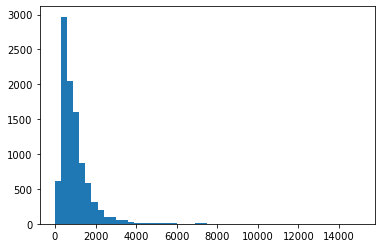

In [30]:
#find pairs small and large
fig = plt.hist(sizes_nf,range = (0, 15000), bins = 50)
#sizes = small <500, large >1500

# Is the similarity correctly detected ?

Now we want to look at the scores of a few processes we know beforehand are similar.